### Imports

In [10]:
# standard library
import sys, copy

# external packages
import torch
from torchvision import datasets, transforms
from torch import nn, optim
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

import syft as sy
import numpy as np
import matplotlib.pyplot as plt

# local packages
from utils import add_ids 
from data_loader import VerticalDataLoader
from class_split_data_loader import ClassSplitDataLoader
from shared_NN import SharedNN

In [20]:
# Initialize important variables
#hook = sy.TorchHook(torch)
torch.manual_seed(0)
n_encoders = 3 #number of encoders we will train
epochs = 20

### Load data

In [21]:
# import data
data_train = add_ids(MNIST)(".", download=True, transform=ToTensor())
data_test  = add_ids(MNIST)(".", train=False, download=True, transform=ToTensor())

In [22]:
# and create dataloaders
dataloaders = []
dataloaders_test = []
for k in range(n_encoders):
    dataloader = ClassSplitDataLoader(data_train, class_to_keep=k, remove_data=False, keep_order=True, batch_size=128) 
    dataloaders.append(dataloader)
    dataloader = ClassSplitDataLoader(data_test, class_to_keep=k, remove_data=False, keep_order=True, batch_size=128) 
    dataloaders_test.append(dataloader)
    # partition_dataset uses by default "remove_data=True, keep_order=False"
    # Do not do this for now

### Create networks

In [23]:

input_size = 784
hidden_sizes = [512, 256]
encoded_size = 128

encoder = nn.Sequential(
        nn.Linear(input_size, hidden_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[0], hidden_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[1], encoded_size),
        nn.ReLU(),
    )
decoder = nn.Sequential(
        nn.Linear(encoded_size, hidden_sizes[1]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[1], hidden_sizes[0]),
        nn.ReLU(),
        nn.Linear(hidden_sizes[0], input_size),
        #nn.LogSoftmax(dim=1),
    )
models = [copy.deepcopy(encoder) for k in range(n_encoders)] + [decoder]

# Create optimisers for each segment and link to them
optimizers = [optim.Adam(model.parameters(), lr=1e-3,) for model in models]


In [24]:
## Define training functions
def forward(encoder_index, input_vector):
    encoder_output = models[encoder_index](input_vector)
    encoded_vector = encoder_output.clone().detach()
    encoded_vector = encoded_vector.requires_grad_()
    decoder = models[-1]
    return encoder_output, encoded_vector, decoder(encoded_vector)

def backward(encoder_output, encoded_vector):
    grads = encoded_vector.grad.clone().detach()
    encoder_output.backward(grads)
    

### Train networks

In [29]:
train_perf, test_perf = [], []
for i in range(epochs):
    running_loss = np.zeros(n_encoders)
    running_test_MSE = np.zeros(n_encoders)
    
    for k in range(n_encoders):
        # for now, train the encoders one after another
        dataloader = dataloaders[k]
        
        for ((data, ids),) in dataloader:
            # Train a model
            data = data.view(data.shape[0], -1)
            
            #1) Zero our grads
            for opt in optimizers:
                opt.zero_grad()
            
            #2) Make a prediction and move it to the encoder
            encoder_output, encoded_vector, pred = forward(k, data)
            
            #3) Figure out how much we missed by
            criterion = nn.MSELoss()
            loss = criterion(pred, data)
            
            #4) Backprop the loss on the end layer
            loss.backward()
            
            #5) Feed Gradients backward through the network
            backward(encoder_output, encoded_vector)
            
            #6) Change the weights
            for opt in optimizers:
                opt.step()

            # Collect statistics
            running_loss[k] += loss.item()
        
        # Evaluate performance on test data
        dataloader_test = dataloaders_test[k]
        for ((data, ids),) in dataloader_test:
            data = data.view(data.shape[0], -1)
            pred = models[-1](models[k](data))
            #accuracy for an autoencoder is the distance between data and pred
            running_test_MSE[k] += nn.MSELoss()(pred,data).item()
            
    
    print(f"Epoch {i}/{epochs}"
            +f" - Training loss: {np.average(running_loss)/len(dataloader)/n_encoders:.4f}"
            +f" - testing MSE: {np.average(running_test_MSE)/len(dataloader_test)/n_encoders:.4f}")
    train_perf.append(running_loss/len(dataloader)/n_encoders)
    test_perf.append(running_test_MSE/len(dataloader_test)/n_encoders)


Epoch 0/20
Epoch 1/20
Epoch 2/20
Epoch 3/20
Epoch 4/20
Epoch 5/20
Epoch 6/20
Epoch 7/20
Epoch 8/20
Epoch 9/20
Epoch 10/20
Epoch 11/20
Epoch 12/20
Epoch 13/20
Epoch 14/20
Epoch 15/20
Epoch 16/20
Epoch 17/20
Epoch 18/20
Epoch 19/20


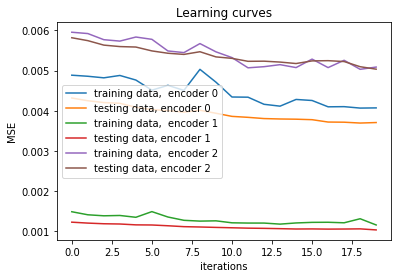

In [42]:
fig = plt.figure()
ax = plt.axes()
train_perf, test_perf = np.array(train_perf), np.array(test_perf)
x = range(epochs)
for k in range(n_encoders):
    ax.plot(x, train_perf[:,k], label=f'training data,  encoder {k}')
    ax.plot(x, test_perf[:,k], label=f'testing data, encoder {k}')

plt.title("Learning curves")
plt.xlabel("iterations")
plt.ylabel("MSE")
plt.legend()
plt.show()

In [38]:
#x=running_loss/len(dataloader)/n_encoders
np.average(x)

0.003439097135739476